# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
import os
os.environ['ARTM_SHARED_LIBRARY']='/Users/dmitrys/bigartm/build/lib/libartm.dylib'

In [6]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [26]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [27]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [28]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [29]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [30]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
#                                           use_unigram_document_model=False,
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [31]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [32]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

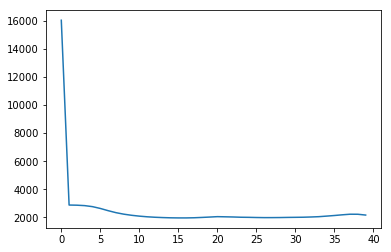

In [33]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [34]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end = " ")
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print(word,end=" ")
    print()

sbj0:  который быть что это человек этот как свой для они его весь такой время себя 
sbj1:  a множитель возведение b скобка x раскладывать умножение сокращенный разложение ответ квадрат слагаемое многочлен выражение 
sbj2:  обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня оборот вера браслет старик сантьяго 
sbj3:  который быть год свой время государство человек мир становиться жизнь северный первый война африка ребенок 
sbj4:  x a b уравнение дробь квадратный y степень функция число f решение корень c пример 
sbj5:  быть год пушкин функция свой его русский который поэт империя культура весь a f трение 
sbj6:  сила быть тело энергия поле при магнитный точка географический наречие если частица например заряд величина 
sbj7:  который что это как человек для этот такой быть являться мочь себя она его свой 
sbj8:  который быть что это свой как этот человек для x они такой государство a весь 
sbj9:  который быть что этот это как человек свой дл

Давайте посмотрим также на разреженность матриц:

In [35]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.7333188396794832
0.1653361344537815


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [36]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [37]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [39]:
# for topic_name in model_artm.topic_names:
#     print topic_name + ': ',
#     tokens = model_artm.score_tracker["top_words"].last_tokens
#     for word in tokens[topic_name]:    
#         print word,
#     print

In [41]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.8168084974222002
0.3025210084033613


Попробуем менять коэффициент регуляризации:

In [42]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [43]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [49]:
for topic_name in model_artm.topic_names:
    print(topic_name + ': ', end = " ")
    tokens = model_artm.score_tracker["top_words"].last_tokens
    try:
        for word in tokens[topic_name]:    
            print(word,end = " ")
        print()
    except:
        continue

sbj0:  предложение вода корень древний квадратный дом n океан жить собственный крестьянин член александр зона достигать 
sbj1:  sbj2:  sbj3:  северный африка сфера конфликт географический ресурс материк остров ядерный климат гражданин цивилизация трудовой животное международный 
sbj4:  sbj5:  функция пушкин империя f определение область промежуток восстание трение существительное английский воспринимать пояс павел падеж 
sbj6:  sbj7:  лермонтов поэма толстой правило иван лиза мертвый общение описывать средство хотеть детство относительно поведение ничто 
sbj8:  x a два b ребенок город равный уравнение сторона y движение условие различный поле выражение 
sbj9:  который быть что это этот человек как свой такой они весь его год жизнь государство 


In [51]:
# еще раз посмотрим на разреженность
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9105099695633269
0.48487394957983193


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [52]:
model_artm.save("my_model")

In [53]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [54]:
phi = model_artm.get_phi()

In [55]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
подвелась,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
фигурка,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
бизон,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
мамонт,0.000000,0.0,0.0,0.000000,0.0,0.000275,0.0,0.000000,0.000000,0.000000
усопший,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
палеолит,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
Sapiens,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
Homo,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
цельсий,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000
условияКлимат,0.000000,0.0,0.0,0.000000,0.0,0.000138,0.0,0.000000,0.000000,0.000000


Матрица вероятностей тем в документах.

In [56]:
theta = model_artm.get_theta()
theta

,100,101,102,103,104,105,106,107,108,109,...,290,291,292,293,294,295,296,297,298,299
sbj0,0.045603,0.070671,0.034384,0.085837,0.165493,0.047847,0.151235,0.096491,0.053872,0.020243,...,0.022951,0.034722,0.042071,0.048309,0.040027,0.142857,0.036866,0.050000,0.047458,0.048276
sbj1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj3,0.058562,0.307421,0.014327,0.347639,0.080986,0.014354,0.086420,0.004386,0.003367,0.097166,...,0.042623,0.041667,0.029126,0.019324,0.221993,0.000000,0.023041,0.003571,0.000000,0.000000
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.010053,0.113074,0.005731,0.012876,0.031690,0.054372,0.033951,0.074561,0.037037,0.008097,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj7,0.096993,0.003534,0.299236,0.017167,0.024648,0.243190,0.030838,0.096459,0.006734,0.068826,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj8,0.042861,0.127208,0.054807,0.103004,0.116197,0.062765,0.071014,0.109681,0.191919,0.064777,...,0.055738,0.055556,0.061489,0.048309,0.112981,0.602041,0.046083,0.053571,0.203390,0.058621
sbj9,0.745928,0.378092,0.591516,0.433476,0.580986,0.577472,0.626543,0.618421,0.707070,0.740890,...,0.878688,0.868055,0.867314,0.884058,0.625000,0.255102,0.894009,0.892857,0.749153,0.893103


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [28]:
theta_test = model_artm.transform(batch_vectorizer)